In [1]:
import pandas as pd
import sys,os, time, glob, re  
import numpy as np
# !pip install awkward pandas

import awkward as ak
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm       
tqdm.pandas()

# import the custom python module
import muonfixedid, chamberlist_run3   
import splitter_regions_Run2
import mdtCalib_functions



ACTIVE_TIME_WINDOW=1.3*(10**(-6))
ADC_CUT_VAL = 50
# NOISE_THRESH=20000

In [2]:
df_raw_merged=pd.read_csv('df_raw_till012.csv')
print(df_raw_merged.shape)
df_raw_merged.head(4)

(969960, 4)


rawMdt_adc  rawMdt_tdc rawMdt_tubeInfo rawMdt_chamber
0         133         231  BIS7A02-2-4-45        BIS7A02
1         149         303  BIS7A02-2-4-44        BIS7A02
2          60         688  BIS7A02-2-4-39        BIS7A02
3         294         575  BIS7A02-2-4-25        BIS7A02

In [3]:
df_trk_merged=pd.read_csv('df_trk_till012.csv')
df_trk_merged.head(4)

trkHit_id  trkHit_adc  trkHit_distRO  trkHit_driftRadius  trkHit_driftTime  \
0   24648744         172       798.0771            1.242786         25.990090   
1   24648744         142      1268.0171            5.429027        123.195100   
2   24648738         124      1375.0468            3.842015         81.098366   
3   24648709         156       454.6326            1.756220         36.903760   

   trkHit_trackIndex  trkHit_triggerTime  trkHit_error  trkHit_nMdtHits  \
0                  0                 0.0      0.180580               27   
1                  0                 0.0      0.085924               23   
2                  0                 0.0      0.107471               26   
3                  0                 0.0      0.161015               24   

   trkHit_resi  trkHit_tdc  trkHit_tubeMeanAdc  trkHit_type trkHit_tubeInfo  \
0    -0.229221         165             146.465            1  BIS7A02-1-1-41   
1     0.132702         295             146.465            1  BIS7A02-1-1-41   
2     0.039990         240             141.923            1  BIS7A02-1-1-35   
3     0.003931         168             154.835            1   BIS7A02-1-1-6   

  trkHit_chamber trkHit_station  
0        BIS7A02            BIS  
1        BIS7A02            BIS  
2        BIS7A02            BIS  
3        BIS7A02            BIS

In [4]:
df_trk_nHits=df_trk_op_chamber.groupby('trkHit_tubeInfo').agg(nHits=('trkHit_tubeInfo','count')).reset_index()
# df_trk_nHits=df_trk_nHits.sort_values(by='mean_adc',ascending=False)
# print(df_trk_nHits[df_trk_nHits['trkHit_tubeInfo']=='BIS7A02-2-2-23'])

filtered_df=df_trk_nHits[['trkHit_tubeInfo'].isin(raw_noisy_list)]
filtered_df
# type(df_trk_nHits)


NameError: name 'df_trk_op_chamber' is not defined

In [ ]:
def mean_adc(df,grp_col, agg_col):
    grouped_data=df.groupby(grp_col).agg(mean_adc=(agg_col,'mean'),nHit=(agg_col,'count')).reset_index()
    grouped_data=grouped_data.sort_values(by='mean_adc', ascending=False)
    return grouped_data
df_raw_grouped_data=mean_adc(df_raw_op_chamber,'rawMdt_tubeInfo','rawMdt_adc')
df_trk_grouped_data=mean_adc(df_trk_op_chamber,'trkHit_tubeInfo','trkHit_adc')

raw_noisy_list = df_raw_grouped_data[df_raw_grouped_data['mean_adc']< 115].rawMdt_tubeInfo.tolist()
# trk_noisy_list = df_trk_grouped_data[df_trk_grouped_data['mean_adc']< 115].trkHit_tubeInfo.tolist()
df_raw_noisy_tubes = df_raw_grouped_data[df_raw_grouped_data['mean_adc']< 115]
# df_trk_noisy_tubes = df_trk_grouped_data[df_trk_grouped_data['mean_adc']< 115]  #doesn't make sense to take mean_adc<115
# print(raw_noisy_list, df_raw_noisy_tubes )
print(df_raw_noisy_tubes)

    rawMdt_tubeInfo    mean_adc  nHit
439  BIS7A02-2-2-23  114.760000    50
349  BIS7A02-2-1-37  113.782051    78
382  BIS7A02-2-1-67  110.452102  3758
454  BIS7A02-2-2-37  110.206349    63
657   BIS7A02-2-4-3  110.064935    77
592  BIS7A02-2-3-67  109.849410  2882
312   BIS7A02-2-1-1  104.750000    76
68   BIS7A02-1-1-71  102.018868    53
666  BIS7A02-2-4-38  101.153285   137
63   BIS7A02-1-1-67   99.123711    97
523   BIS7A02-2-3-1   96.247934   121
628   BIS7A02-2-4-1   91.219298   114
64   BIS7A02-1-1-68   88.458824   170
645  BIS7A02-2-4-19   82.679198   399
699  BIS7A02-2-4-68   81.022923   349
691  BIS7A02-2-4-60   80.585004  1347
696  BIS7A02-2-4-65   78.431336  1602
60   BIS7A02-1-1-64   77.365854   246
593  BIS7A02-2-3-68   76.538462   117
62   BIS7A02-1-1-66   76.435028   177
685  BIS7A02-2-4-55   75.604775   377
730  BIS7A02-2-4-97   74.232614   417
689  BIS7A02-2-4-59   73.191271   779
591  BIS7A02-2-3-66   73.116541   266
67   BIS7A02-1-1-70   72.196539   809
414  BIS7A02

In [ ]:
# plotting function for chamber hitMap and noise_hits  
def plotHitMap(df,chamber):
    chamberinfo = list(df.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]

    fig,ax = plt.subplots(figsize=(8,6))
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    # ax.set_title()
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = ax.hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[0,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=ax)
    plt.show()

plotHitMap(df_raw_op_chamber,'BIS7A02')

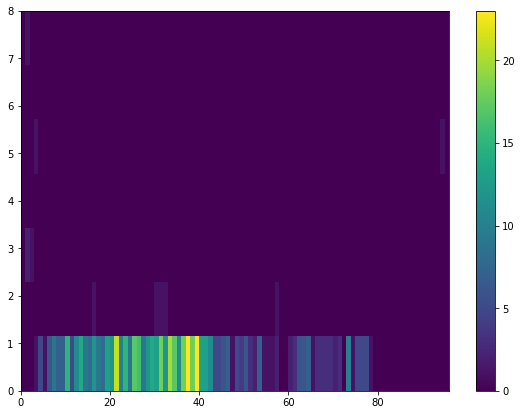

In [ ]:
def plotHitMap(df,chamber):
    chamberinfo = list(df.trkHit_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]

    fig,ax = plt.subplots(figsize=(8,6))
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    # ax.set_title()
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = ax.hist2d(tb,nLayer, bins = [96,7], range= [[0,96],[0,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=ax)
    plt.show()

plotHitMap(df_trk_op_chamber,'BIS7A02')

In [ ]:
import uproot
import pandas as pd
import sys,os, time, glob, re  
import numpy as np
# !pip install awkward pandas
import awkward as ak
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm       
tqdm.pandas()
# import ROOT

# import the custom python module
import muonfixedid, chamberlist_run3   
import splitter_regions_Run2
import mdtCalib_functions



ACTIVE_TIME_WINDOW=1.3*(10**(-6))
ADC_CUT_VAL = 50
# NOISE_THRESH=20000


inputCalibNtuple= 
f=uproot.open(inputCalibNtuple)  
tree=f['Segments']                                     
run = inputCalibNtuple.split('0',1)[1][:6]        
region = int(inputCalibNtuple.split("-", 1)[1][:4])
lb = inputCalibNtuple.split("-", 1)[0][-9:]          
branchList=tree.keys()                                  
branchPrefix=['trk', 'trkHit', 'event', 'rawMdt']       
branchMapping={key : [] for key in branchPrefix}          # branchMapping is a dictionary

for branch in branchList:
    branchName, variableName= branch.split('_', 1)
    if branchName in branchPrefix:
        branchMapping[branchName].append(branch)
        
# convert mdtCalname to mdtHardname by chamberlist.py
chamberInRegion = [chamberlist_run3.MDThardname(chamberlist_run3.MDTindex(x)) for x in splitter_regions_Run2.regionlist[region]]
print('process run %s lumiblock %s region %s, chamberList %s' % (run, lb, region, chamberInRegion))

df_all = tree.arrays() #gives total numner of events and not hits
total_evts=len(df_all)

print(f'Total Events in this data file is {total_evts}')

df_raw=ak.to_pandas(tree.arrays(branchMapping['rawMdt'])) #convert awkward array to dataframe 
df_raw.columns

# expand all raw and trk hits with correct chamberName and tubeInfo
df_raw['rawMdt_tubeInfo'] = df_raw['rawMdt_id'].apply(lambda x : chamberlist_run3.MDTtubename(int(x)))
df_raw['rawMdt_chamber'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:7])
df_raw['rawMdt_station'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:3])
print(f'Total number of rows and columns in chambers {chamberInRegion} is {df_raw.shape}')

df_trk=ak.to_pandas(tree.arrays(branchMapping['trkHit']))

# expand all trk hits with correct chamberName and tubeInfo
df_trk['trkHit_tubeInfo'] = df_trk['trkHit_id'].apply(lambda x : chamberlist_run3.MDTtubename(int(x))) #got the track info

df_trk['trkHit_chamber'] = df_trk['trkHit_tubeInfo'].apply(lambda x :x[:7])
df_trk['trkHit_station'] = df_trk['trkHit_tubeInfo'].apply(lambda x :x[:3])
print(f'Total number of rows and columns in chambers for track hits {chamberInRegion} is {df_trk.shape}')


df_raw_op_chamber=df_raw[df_raw['rawMdt_chamber']=='BIS7A02']
df_trk_op_chamber=df_trk[df_trk['trkHit_chamber']=='BIS7A02'] #contains BIS6A0..

print(df_raw_op_chamber, df_trk_op_chamber)

process run 047678 lumiblock 0001_0004 region 113, chamberList ['IsWRONG', 'BIS7A02', 'EES1A02', 'EES2A02', 'EMS4A02', 'EMS5A02']
Total Events in this data file is 8406
Total number of rows and columns in chambers ['IsWRONG', 'BIS7A02', 'EES1A02', 'EES2A02', 'EMS4A02', 'EMS5A02'] is (881189, 10)
Total number of rows and columns in chambers for track hits ['IsWRONG', 'BIS7A02', 'EES1A02', 'EES2A02', 'EMS4A02', 'EMS5A02'] is (7388, 43)
                rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
0     0                133   4309.250977   1780.442993   6397.052734   
      1                149   4309.225586   1780.475342   6381.952148   
      2                 60   4309.098633   1780.637329   6306.449219   
      3                294   4308.743652   1781.090942   6095.041504   
      4                257   4308.718262   1781.123413   6079.941406   
...                    ...           ...           ...    